<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment%204/6_8_Assignment_4_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.kaggle.com/code/tilasousa/face-mask-detection-using-keras-cnn

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from scipy.spatial import distance
import glob
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report , confusion_matrix
from skimage import io
filterwarnings("ignore")

from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow_datasets as tfds
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join

In [3]:
## Accuracy and Loss Graph
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

## Validation Report
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

## Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# defining callback function to avoid overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 6, 
                                        restore_best_weights = True, verbose=1)

# EDA

The path is created for getting data and then I concatened dataframes of mask and without mask.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
path  = '/content/gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/Face Mask Dataset/'

In [6]:
# train dataset
train_dir = os.path.join(path, 'Train')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 10000 files belonging to 2 classes.


In [7]:
# validation dataset
validation_dir = os.path.join(path, 'Validation')

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 800 files belonging to 2 classes.


In [8]:
# test dataset
test_dir = os.path.join(path, 'Test')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 992 files belonging to 2 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


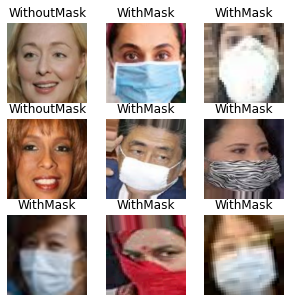

In [10]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
# autotune buffer to avoid I/0 block
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
validation_ds = validation_ds.cache().prefetch(buffer_size=autotune)

# Model 6

Base: Model 3 - best 85%

Sequential model

Input layer

Hidden layer 1: Dense 250 units, Relu activation + Dropout (0.30)

Hidden layer 2: Dense 350 units, Relu activation + Dropout (0.30)

Hidden layer 3: Dense 250 units, Relu activation + Dropout (0.30)

Hidden layer 4: Dense 100 units, Relu activation + Dropout (0.30)

Output layer: Dense 2 units, Softmax activation

In [12]:
model6 = Sequential()
tf.keras.layers.Rescaling(1./255),
model6.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model6.add(layers.Dense(units = 250, activation = "relu"))
model6.add(Dropout(0.30))
model6.add(layers.Dense(units = 350, activation = "relu"))
model6.add(Dropout(0.30))
model6.add(layers.Dense(units = 250, activation = "relu"))
model6.add(Dropout(0.30))
model6.add(layers.Dense(units = 100, activation = "relu"))
model6.add(Dropout(0.30))
model6.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 250)               49152250  
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 350)               87850     
                                                                 
 dropout_1 (Dropout)         (None, 350)               0         
                                                                 
 dense_2 (Dense)             (None, 250)               87750     
                                                                 
 dropout_2 (Dropout)         (None, 250)               0

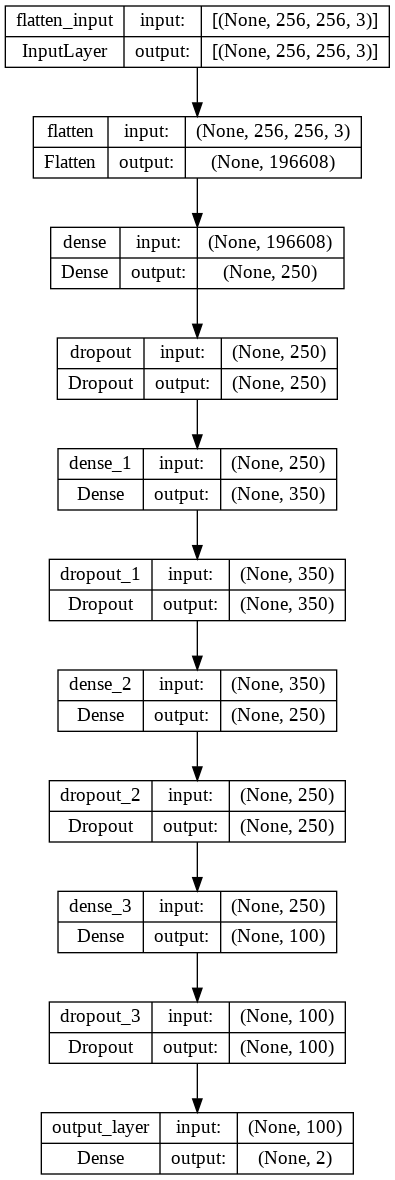

In [13]:
keras.utils.plot_model(model6, "model6.png", show_shapes=True) 

In [14]:
model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
## Train 
history6 = model6.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model6.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 285s 903ms/step - loss: 695.9562 - accuracy: 0.5186 - val_loss: 1.0806 - val_accuracy: 0.4950
Epoch 2/200
313/313 [==============================] - 4s 14ms/step - loss: 0.7585 - accuracy: 0.5044 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 3/200
313/313 [==============================] - 3s 11ms/step - loss: 0.7124 - accuracy: 0.5082 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/200
313/313 [==============================] - 3s 11ms/step - loss: 0.7356 - accuracy: 0.5019 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 5/200
313/313 [==============================] - 3s 11ms/step - loss: 0.7580 - accuracy: 0.5080 - val_loss: 0.6934 - val_accuracy: 0.5000


In [16]:
model6 = tf.keras.models.load_model("DNN_model6.h5")
print(f"Test acc: {model6.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 30s 712ms/step - loss: 0.6927 - accuracy: 0.4869
Test acc: 0.487


## Evaluate

In [17]:
history_dict6 = history6.history
history_dict6.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [18]:
history_df6=pd.DataFrame(history_dict6)
history_df6.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,695.956,0.519,1.081,0.495
1,0.758,0.504,0.693,0.500
2,0.712,0.508,0.693,0.500
3,0.736,0.502,0.693,0.500
4,0.758,0.508,0.693,0.500


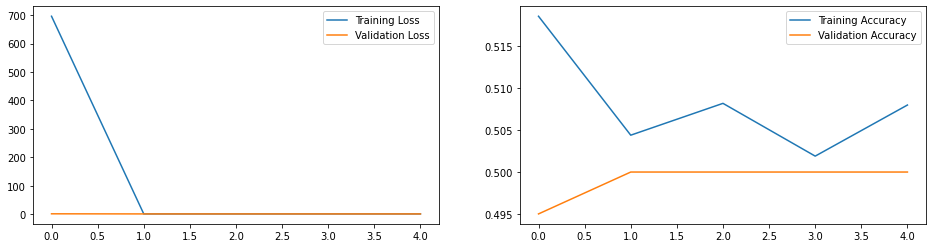

In [19]:
## Loss and acuracy
plot_history(history6)

In [20]:
test_pred6 = model6.predict(test_ds)
test_pred6 = np.argmax(test_pred6,axis = 1)
test_labels6 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 17ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

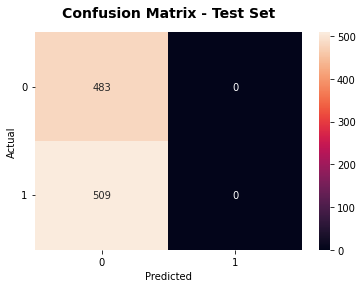

In [21]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels6,
    test_pred6,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [22]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 0 with mask and 483 without mask

In [23]:
import numpy
from sklearn import metrics

actual6 = test_labels6
predicted6 = test_pred6

Accuracy = metrics.accuracy_score(actual6, predicted6)
Precision = metrics.precision_score(actual6, predicted6)
Sensitivity_recall = metrics.recall_score(actual6, predicted6)
Specificity = metrics.recall_score(actual6, predicted6, pos_label=0)
F1_score = metrics.f1_score(actual6, predicted6)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.48689516129032256, 'Precision': 0.0, 'Sensitivity_recall': 0.0, 'Specificity': 1.0, 'F1_score': 0.0}


In [24]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual6, predicted6, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.49      1.00      0.65       483
 withoutMask       0.00      0.00      0.00       509

    accuracy                           0.49       992
   macro avg       0.24      0.50      0.33       992
weighted avg       0.24      0.49      0.32       992



# Model 7

Sequential model

Input layer

Hidden layer 1: Dense 250 units, Relu activation + Dropout (0.30)

Hidden layer 2: Dense 350 units, Relu activation + Dropout (0.30)

Output layer: Dense 2 units, Softmax activation

In [25]:
model7 = Sequential()
tf.keras.layers.Rescaling(1./255),
model7.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model7.add(layers.Dense(units = 250, activation = "relu"))
model7.add(Dropout(0.10))
model7.add(layers.Dense(units = 350, activation = "relu"))
model7.add(Dropout(0.10))
model7.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_4 (Dense)             (None, 250)               49152250  
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_5 (Dense)             (None, 350)               87850     
                                                                 
 dropout_5 (Dropout)         (None, 350)               0         
                                                                 
 output_layer (Dense)        (None, 2)                 702       
                                                                 
Total params: 49,240,802
Trainable params: 49,240,802


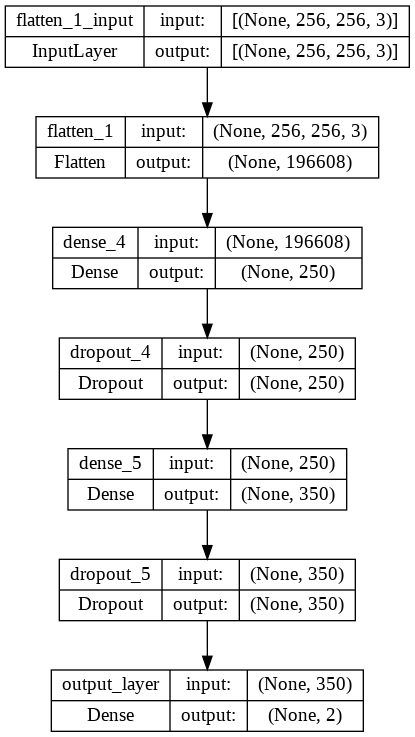

In [26]:
keras.utils.plot_model(model7, "model7.png", show_shapes=True) 

In [27]:
model7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [28]:
## Train 
history7 = model7.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model7.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 5s 13ms/step - loss: 655.2798 - accuracy: 0.6584 - val_loss: 0.6038 - val_accuracy: 0.6162
Epoch 2/200
313/313 [==============================] - 3s 10ms/step - loss: 0.7011 - accuracy: 0.5628 - val_loss: 0.6666 - val_accuracy: 0.5387
Epoch 3/200
313/313 [==============================] - 3s 10ms/step - loss: 0.6823 - accuracy: 0.5496 - val_loss: 0.6848 - val_accuracy: 0.5138
Epoch 4/200
313/313 [==============================] - 3s 10ms/step - loss: 0.6875 - accuracy: 0.5176 - val_loss: 0.6848 - val_accuracy: 0.5125


In [29]:
model7 = tf.keras.models.load_model("DNN_model7.h5")
print(f"Test acc: {model7.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 17ms/step - loss: 0.6067 - accuracy: 0.6240
Test acc: 0.624


## Evaluate

In [30]:
history_dict7 = history7.history
history_dict7.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
history_df7=pd.DataFrame(history_dict7)
history_df7.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,655.280,0.658,0.604,0.616
1,0.701,0.563,0.667,0.539
2,0.682,0.550,0.685,0.514
3,0.688,0.518,0.685,0.512


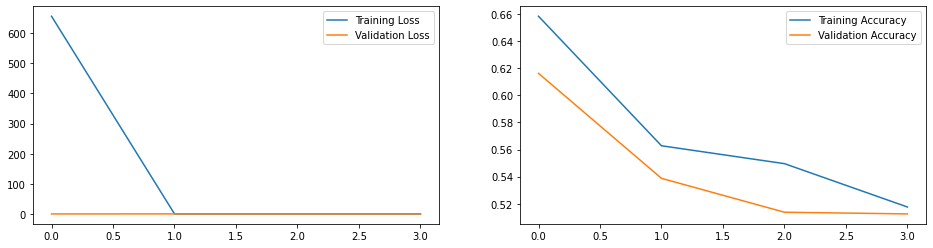

In [32]:
## Loss and acuracy
plot_history(history7)

In [33]:
test_pred7 = model7.predict(test_ds)
test_pred7 = np.argmax(test_pred7,axis = 1)
test_labels7 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 17ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

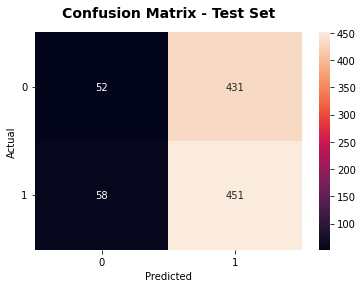

In [34]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels7,
    test_pred7,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [35]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 85 with mask and 403 without mask

In [36]:
actual7 = test_labels7
predicted7 = test_pred7

Accuracy = metrics.accuracy_score(actual7, predicted7)
Precision = metrics.precision_score(actual7, predicted7)
Sensitivity_recall = metrics.recall_score(actual7, predicted7)
Specificity = metrics.recall_score(actual7, predicted7, pos_label=0)
F1_score = metrics.f1_score(actual7, predicted7)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.5070564516129032, 'Precision': 0.5113378684807256, 'Sensitivity_recall': 0.8860510805500982, 'Specificity': 0.10766045548654245, 'F1_score': 0.6484543493889288}


In [37]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual7, predicted7, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.47      0.11      0.18       483
 withoutMask       0.51      0.89      0.65       509

    accuracy                           0.51       992
   macro avg       0.49      0.50      0.41       992
weighted avg       0.49      0.51      0.42       992



# Model 8

Base: Model 3 - best 85%

Sequential model

Input layer

Hidden layer 1: Dense 250 units, Relu activation + Dropout (0.10)

Hidden layer 2: Dense 350 units, Relu activation + Dropout (0.10)

Hidden layer 3: Dense 250 units, Relu activation + Dropout (0.10)

Hidden layer 4: Dense 100 units, Relu activation + Dropout (0.10)

Output layer: Dense 2 units, Softmax activation

In [38]:
model8 = Sequential()
tf.keras.layers.Rescaling(1./255),
model8.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model8.add(layers.Dense(units = 250, activation = "relu"))
model8.add(Dropout(0.10))
model8.add(layers.Dense(units = 350, activation = "relu"))
model8.add(Dropout(0.10))
model8.add(layers.Dense(units = 250, activation = "relu"))
model8.add(Dropout(0.10))
model8.add(layers.Dense(units = 100, activation = "relu"))
model8.add(Dropout(0.10))
model8.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 196608)            0         
                                                                 
 dense_6 (Dense)             (None, 250)               49152250  
                                                                 
 dropout_6 (Dropout)         (None, 250)               0         
                                                                 
 dense_7 (Dense)             (None, 350)               87850     
                                                                 
 dropout_7 (Dropout)         (None, 350)               0         
                                                                 
 dense_8 (Dense)             (None, 250)               87750     
                                                                 
 dropout_8 (Dropout)         (None, 250)              

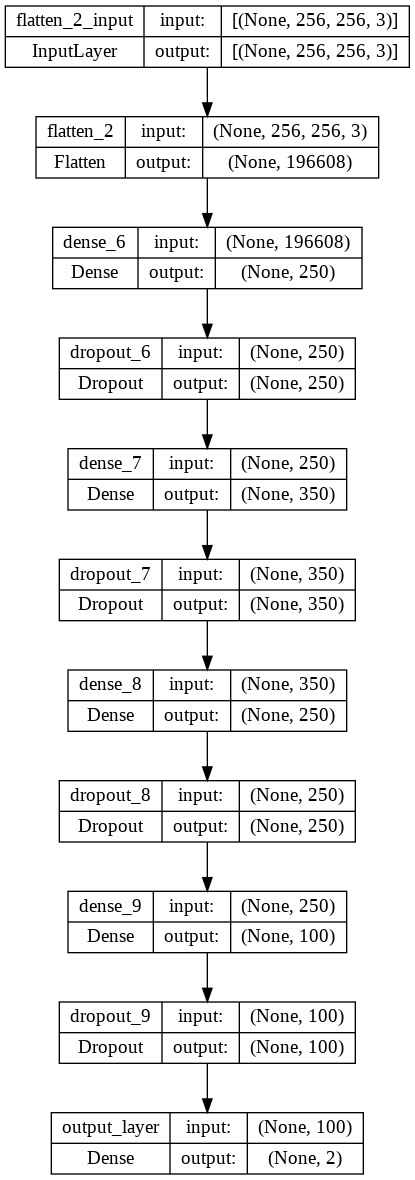

In [39]:
keras.utils.plot_model(model8, "model8.png", show_shapes=True) 

In [40]:
model8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [41]:
## Train 
history8 = model8.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model8.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 5s 14ms/step - loss: 516.8170 - accuracy: 0.6681 - val_loss: 0.6109 - val_accuracy: 0.7125
Epoch 2/200
313/313 [==============================] - 3s 11ms/step - loss: 0.8518 - accuracy: 0.6220 - val_loss: 0.6714 - val_accuracy: 0.5325
Epoch 3/200
313/313 [==============================] - 3s 11ms/step - loss: 0.8232 - accuracy: 0.5305 - val_loss: 0.6853 - val_accuracy: 0.5100
Epoch 4/200
313/313 [==============================] - 3s 11ms/step - loss: 0.7010 - accuracy: 0.5170 - val_loss: 0.6856 - val_accuracy: 0.5000


In [42]:
model8 = tf.keras.models.load_model("DNN_model8.h5")
print(f"Test acc: {model8.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 17ms/step - loss: 0.8536 - accuracy: 0.7369
Test acc: 0.737


## Evaluate

In [43]:
history_dict8 = history8.history
history_dict8.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [44]:
history_df8=pd.DataFrame(history_dict8)
history_df8.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,516.817,0.668,0.611,0.712
1,0.852,0.622,0.671,0.533
2,0.823,0.530,0.685,0.510
3,0.701,0.517,0.686,0.500


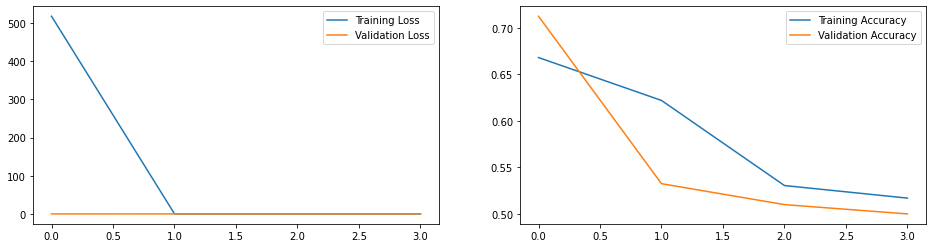

In [45]:
## Loss and acuracy
plot_history(history8)

In [46]:
test_pred8 = model8.predict(test_ds)
test_pred8 = np.argmax(test_pred8,axis = 1)
test_labels8 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 17ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

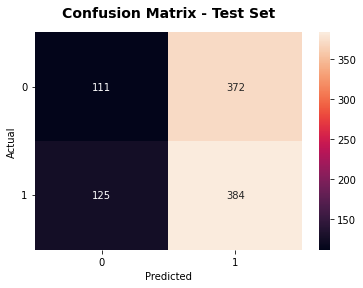

In [47]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels8,
    test_pred8,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [48]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 82 with mask and 403 without mask

In [49]:
actual8 = test_labels8
predicted8 = test_pred8

Accuracy = metrics.accuracy_score(actual8, predicted8)
Precision = metrics.precision_score(actual8, predicted8)
Sensitivity_recall = metrics.recall_score(actual8, predicted8)
Specificity = metrics.recall_score(actual8, predicted8, pos_label=0)
F1_score = metrics.f1_score(actual8, predicted8)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.49899193548387094, 'Precision': 0.5079365079365079, 'Sensitivity_recall': 0.7544204322200393, 'Specificity': 0.22981366459627328, 'F1_score': 0.6071146245059288}


In [50]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual8, predicted8, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.47      0.23      0.31       483
 withoutMask       0.51      0.75      0.61       509

    accuracy                           0.50       992
   macro avg       0.49      0.49      0.46       992
weighted avg       0.49      0.50      0.46       992

